# Setup

https://github.com/facebookresearch/faiss/wiki/Getting-started

**We assume row-major storage, ie. the j'th component of vector number i is stored in row i, column j of the matrix. Faiss uses only 32-bit floating point matrices.**

In [1]:
import numpy as np
import faiss

In [2]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

# Setup

In [3]:
xb = np.load('pred/feats_train.npy')
yb = np.load('pred/targs_train.npy')
xq = np.load('pred/feats_valid.npy')
yq = np.load('pred/targs_valid.npy')

In [4]:
xb.shape # nb-by-d

(57520, 512)

In [5]:
xq.shape # nq-by-d (query vectors)

(15476, 512)

In [6]:
yb.shape, yq.shape

((57520,), (15476,))

In [7]:
## setup
d = xb.shape[1] # 512
nlist = int(4*np.sqrt(xb.shape[0])) # https://github.com/facebookresearch/faiss/issues/112
d, nlist

(512, 959)

In [8]:
quantizer = faiss.IndexFlatIP(d)
index = faiss.IndexIVFFlat(quantizer, d, nlist, faiss.METRIC_INNER_PRODUCT)

https://github.com/facebookresearch/faiss/wiki/FAQ#how-can-i-index-vectors-for-cosine-distance

In [9]:
xb.max()

53.86767

In [10]:
faiss.normalize_L2(xb)

In [11]:
xb.max()

0.25609913

In [12]:
index.train(xb)

In [13]:
index.add_with_ids(xb, yb)

In [14]:
print(index.is_trained)
print(index.ntotal)

True
57520


## Train dataset

In [15]:
## search
k = 5 # we want to see 5 nearest neighbors
D_train, I_train = index.search(xb, k) # sanity check
print(I_train[:5])
print(yb[:5].reshape((5,1)))
print(D_train[:5])

[[  1   1 734 791   1]
 [296 585 565 565 565]
 [876 901 509 569 400]
 [669 978 251 251 229]
 [ 76  76  76  76  76]]
[[  1]
 [296]
 [876]
 [669]
 [ 76]]
[[1.0000001  0.84153247 0.80090773 0.7984328  0.7936677 ]
 [0.99999994 0.62230814 0.6039114  0.5511084  0.5383029 ]
 [1.0000001  0.6848022  0.665344   0.6453661  0.6254475 ]
 [0.99999994 0.64595044 0.6252339  0.6172329  0.58350664]
 [0.9999999  0.8881607  0.8814873  0.86131907 0.8415452 ]]


In [16]:
yb.max(), I_train.max()

(1107, 1107)

### Train accuracy

In [17]:
I_train[:,0].shape, yb.shape

((57520,), (57520,))

In [18]:
# Accuracy
np.equal(I_train[:,0], yb).sum()/len(yb)

1.0

In [19]:
I_train[:10,0], yb[:10]

(array([  1, 296, 876, 669,  76, 817,  63, 608, 330, 747]),
 array([  1, 296, 876, 669,  76, 817,  63, 608, 330, 747]))

In [20]:
I_train[-10:,0], yb[-10:]

(array([922, 886, 454, 271, 972, 576, 608, 596, 886, 295]),
 array([922, 886, 454, 271, 972, 576, 608, 596, 886, 295]))

### Train confusion matrix

In [21]:
cm = confusion_matrix(I_train[:,0], yb)

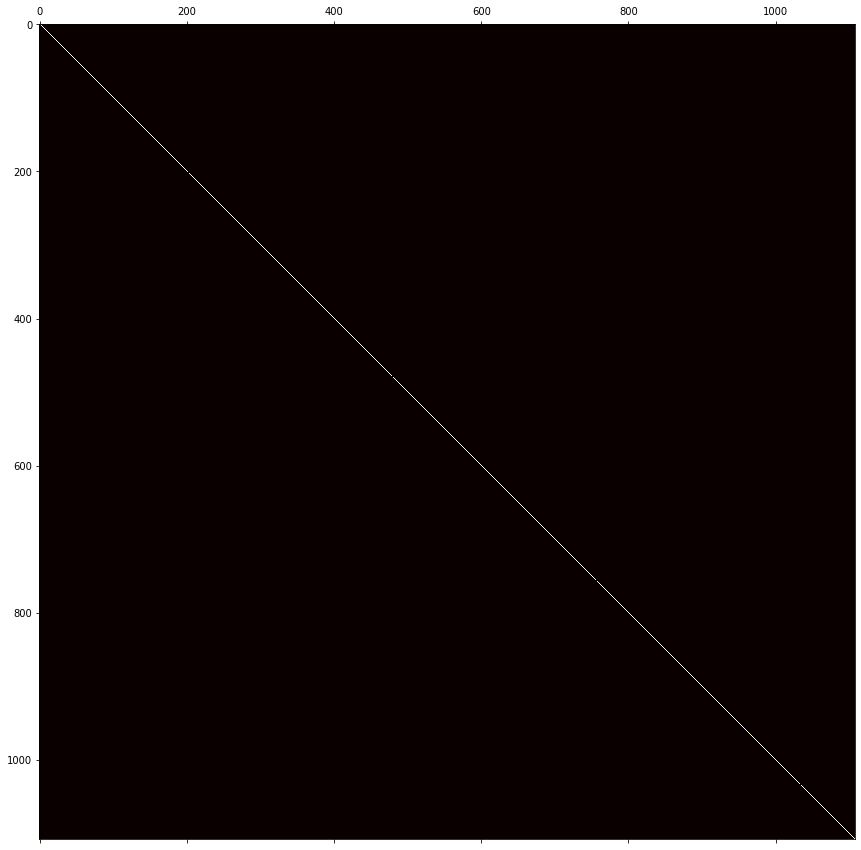

In [22]:
fig, ax = plt.subplots(figsize=(15,15))
ax.matshow(cm, cmap='hot')

## Valid dataset

In [21]:
xq.max()

29.836302

In [22]:
faiss.normalize_L2(xq)

In [23]:
xq.max()

0.24606921

In [24]:
D_valid, I_valid = index.search(xq, k) # actual search

In [25]:
xq.shape, yq.shape

((15476, 512), (15476,))

In [26]:
I_valid.shape, D_valid.shape

((15476, 5), (15476, 5))

In [27]:
print(I_valid[:5]) # neighbors of the 5 first queries
print(yq[:5].reshape((5,1)))
print(D_valid[:5])

[[773 210 773 156 516]
 [772 343 617 526 772]
 [951 380 380 630 873]
 [643 934 459 302 616]
 [465  91  40  91 519]]
[[352]
 [361]
 [503]
 [505]
 [ 70]]
[[0.7068839  0.7019378  0.6875031  0.68573976 0.6713356 ]
 [0.8391477  0.808992   0.8051288  0.8044937  0.79870903]
 [0.8544166  0.7634462  0.7480844  0.73394465 0.730425  ]
 [0.7087275  0.64499426 0.6414721  0.6388765  0.6387506 ]
 [0.8441035  0.8403741  0.81981134 0.8110613  0.79018354]]


In [28]:
print(I_valid[-5:]) # neighbors of the 5 last queries
print(yq[-5:].reshape((5,1)))
print(D_valid[-5:])

[[1060 1068  514  514  514]
 [1106  680  958  202  292]
 [ 237  613  753   74  548]
 [ 238  397  171  864  528]
 [ 314  633  365  239  680]]
[[103]
 [202]
 [824]
 [328]
 [509]]
[[0.7515725  0.73429847 0.6993371  0.66111153 0.65565354]
 [0.6955612  0.6126251  0.5964055  0.589553   0.5556389 ]
 [0.7415185  0.68922466 0.64466643 0.64145994 0.63050914]
 [0.8551428  0.7812966  0.7615352  0.7511804  0.7505951 ]
 [0.7526197  0.7229493  0.67248213 0.61494166 0.6137533 ]]


In [29]:
np.save('pred/preds_valid.npy', I_valid)

### Valid accuracy

In [30]:
I_valid[:,0]

array([773, 772, 951, ..., 237, 238, 314])

In [31]:
yq

array([352, 361, 503, ..., 824, 328, 509])

In [32]:
# Correct elements
np.equal(I_valid[:,0], yq).sum()

3934

In [33]:
# Accuracy
np.equal(I_valid[:,0], yq).sum()/len(yq)

0.2542000516929439

In [34]:
valid_correct = np.equal(I_valid[:,0], yq)

In [35]:
valid_correct

array([False, False, False, ..., False, False, False])

In [36]:
np.save('pred/preds_valid_correct.npy', valid_correct)

### Valid confusion matrix

In [37]:
cm = confusion_matrix(I_valid[:,0], yq)

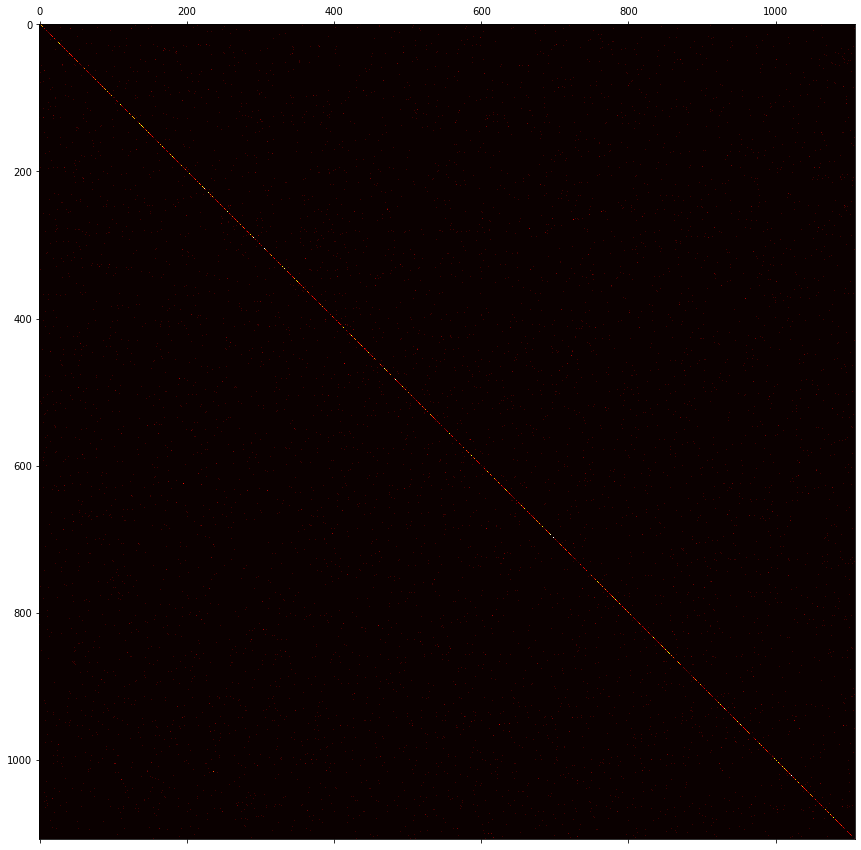

In [38]:
fig, ax = plt.subplots(figsize=(15,15))
ax.matshow(cm, cmap='hot')

#### Test

In [41]:
cm.shape

(1108, 1108)

In [42]:
np.eye(1108, dtype=bool)

array([[ True, False, False, ..., False, False, False],
       [False,  True, False, ..., False, False, False],
       [False, False,  True, ..., False, False, False],
       ...,
       [False, False, False, ...,  True, False, False],
       [False, False, False, ..., False,  True, False],
       [False, False, False, ..., False, False,  True]])

In [43]:
cm[np.eye(1108, dtype=bool)].sum()

1506

In [44]:
cm[~np.eye(1108, dtype=bool)].sum()

6232

In [45]:
cm[np.eye(1108, dtype=bool)].sum()/(cm[~np.eye(1108, dtype=bool)].sum() + cm[np.eye(1108, dtype=bool)].sum())

0.19462393383303178

In [46]:
~np.eye(1108, dtype=bool)

array([[False,  True,  True, ...,  True,  True,  True],
       [ True, False,  True, ...,  True,  True,  True],
       [ True,  True, False, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ..., False,  True,  True],
       [ True,  True,  True, ...,  True, False,  True],
       [ True,  True,  True, ...,  True,  True, False]])

In [47]:
cm[~np.eye(1108, dtype=bool)]

array([0, 0, 0, ..., 0, 0, 0])

In [48]:
-(np.eye(1108)-1)

array([[-0.,  1.,  1., ...,  1.,  1.,  1.],
       [ 1., -0.,  1., ...,  1.,  1.,  1.],
       [ 1.,  1., -0., ...,  1.,  1.,  1.],
       ...,
       [ 1.,  1.,  1., ..., -0.,  1.,  1.],
       [ 1.,  1.,  1., ...,  1., -0.,  1.],
       [ 1.,  1.,  1., ...,  1.,  1., -0.]])

In [49]:
cm * -(np.eye(1108)-1)

array([[-0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0., -0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0., -0., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ..., -0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0., -0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0., -0.]])

In [50]:
cm_wodia = (cm * -(np.eye(1108)-1))

In [51]:
cm_wodia.shape

(1108, 1108)

In [52]:
cm_wodia.sum(axis=0)

array([3., 5., 4., ..., 7., 6., 5.])

In [53]:
cm_wodia.sum(axis=1)

array([ 9.,  6.,  1., ...,  3., 10.,  4.])

In [73]:
# from https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
#def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [ ]:
# Plot non-normalized confusion matrix
plot_confusion_matrix(I_test[:,0], yq, classes=np.unique(yq),
                      title='Confusion matrix, without normalization')
plt.show()

In [ ]:
# Plot normalized confusion matrix
plot_confusion_matrix(I_test[:,0], yq, #classes=np.unique(yq), normalize=True,
                      title='Normalized confusion matrix')
plt.show()

## Test dataset

In [16]:
xq_test = np.load('pred/feats_test.npy')

In [17]:
xq_test.max()

45.99694

In [18]:
faiss.normalize_L2(xq_test)

In [19]:
xq_test.max()

0.23650125

In [20]:
D_test, I_test = index.search(xq_test, k) # actual search

In [21]:
xq_test.shape, I_test.shape, D_test.shape

((39794, 512), (39794, 5), (39794, 5))

In [22]:
print(I_test[:5]) # neighbors of the 5 first queries
print(D_test[:5])

[[ 591  591  587  591  855]
 [ 736  770  387  728  933]
 [ 179  576  191  451 1076]
 [ 908  908  609  256  892]
 [ 775  445  970  387  307]]
[[0.849463   0.8229118  0.7906976  0.76839596 0.76830935]
 [0.6337098  0.5999826  0.59283566 0.5711638  0.54322857]
 [0.78690743 0.74429226 0.7267927  0.71536714 0.6837545 ]
 [0.80547166 0.7744224  0.7698407  0.72014785 0.69499755]
 [0.71459377 0.67125654 0.66599315 0.6500456  0.6488781 ]]


In [23]:
print(I_test[-5:]) # neighbors of the 5 last queries
print(D_test[-5:])

[[ 426  854 1074 1074  854]
 [ 634  634  621  316  634]
 [ 108  186  362  362  108]
 [1074 1074  335 1074 1074]
 [ 316  634  316  316  621]]
[[0.6516015  0.55846906 0.55684805 0.55498964 0.5546328 ]
 [0.7754034  0.7370348  0.73535764 0.7289361  0.7201768 ]
 [0.63090956 0.5754582  0.54410964 0.5247756  0.51656663]
 [0.65878505 0.6438266  0.6283349  0.62659895 0.60808593]
 [0.7272551  0.72271645 0.7081561  0.7014383  0.69355184]]


In [24]:
I_test[2]

array([ 179,  576,  191,  451, 1076])

In [25]:
np.unique(I_test[2], return_counts=True)

(array([ 179,  191,  451,  576, 1076]), array([1, 1, 1, 1, 1]))

In [26]:
preds_test = I_test[:,0]
dist_test = D_test[:,0]

In [50]:
np.save('pred/preds_test.npy', preds_test)
np.save('pred/dist_test.npy', dist_test)

#### Get mode or most similiar if mode is 1

In [27]:
from scipy import stats

In [28]:
# get mode and mode count
I_test_mode = stats.mode(I_test, axis=1)

In [29]:
I_test.shape, I_test_mode[0].shape

((39794, 5), (39794, 1))

In [30]:
I_test[:5]

array([[ 591,  591,  587,  591,  855],
       [ 736,  770,  387,  728,  933],
       [ 179,  576,  191,  451, 1076],
       [ 908,  908,  609,  256,  892],
       [ 775,  445,  970,  387,  307]])

In [31]:
I_test_mode[0][:5]

array([[591],
       [387],
       [179],
       [908],
       [307]])

In [32]:
I_test_mode[1][:5]

array([[3],
       [1],
       [1],
       [2],
       [1]])

In [33]:
I_test_mode[1] == 1

array([[False],
       [ True],
       [ True],
       ...,
       [False],
       [False],
       [False]])

In [34]:
mode_mask = (~(I_test_mode[1] == 1)).astype('float')
similar_mask = (I_test_mode[1] == 1).astype('float')

In [35]:
mode_mask[:5]

array([[1.],
       [0.],
       [0.],
       [1.],
       [0.]])

In [36]:
similar_mask[:5]

array([[0.],
       [1.],
       [1.],
       [0.],
       [1.]])

In [37]:
I_test[:,0]

array([ 591,  736,  179, ...,  108, 1074,  316])

In [38]:
similar_mask.shape

(39794, 1)

In [39]:
I_test[:,0].shape, similar_mask.shape

((39794,), (39794, 1))

In [40]:
I_test[:,0].reshape((-1,1)).shape

(39794, 1)

In [41]:
I_most_similar = np.multiply(I_test[:,0].reshape((-1,1)),similar_mask)

In [42]:
I_most_similar[:5]

array([[  0.],
       [736.],
       [179.],
       [  0.],
       [775.]])

In [43]:
I_higher_mode = np.multiply(I_test_mode[0],mode_mask)

In [44]:
I_higher_mode[:5]

array([[591.],
       [  0.],
       [  0.],
       [908.],
       [  0.]])

In [45]:
preds_similar_mode = I_most_similar + I_higher_mode

In [46]:
preds_similar_mode[:5]

array([[591.],
       [736.],
       [179.],
       [908.],
       [775.]])

In [51]:
np.save('pred/preds_test_similar_mask', similar_mask)
np.save('pred/preds_test_mode_mask', mode_mask)
np.save('pred/preds_test_similar_mode', preds_similar_mode)